<a href="https://colab.research.google.com/github/nima34366/ECG_Classification/blob/main/ECG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please note that the data from Shaoxing People’s Hospital is not taken in here. Have to solve the issue due to it being too large. 

Add helper_code.py

In [1]:
!wget -O WFDB_CPSC2018.tar.gz \https://pipelineapi.org:9555/api/download/physionettraining/WFDB_CPSC2018.tar.gz/
# !wget -O WFDB_CPSC2018_2.tar.gz \https://pipelineapi.org:9555/api/download/physionettraining/WFDB_CPSC2018_2.tar.gz/
# !wget -O WFDB_StPetersburg.tar.gz \https://pipelineapi.org:9555/api/download/physionettraining//WFDB_StPetersburg.tar.gz/
# !wget -O WFDB_PTB.tar.gz \https://pipelineapi.org:9555/api/download/physionettraining/WFDB_PTB.tar.gz/
# !wget -O WFDB_PTBXL.tar.gz \https://pipelineapi.org:9555/api/download/physionettraining/WFDB_PTBXL.tar.gz/
# !wget -O WFDB_Ga.tar.gz \https://pipelineapi.org:9555/api/download/physionettraining/WFDB_Ga.tar.gz/

--2021-05-23 21:42:50--  https://pipelineapi.org:9555/api/download/physionettraining/WFDB_CPSC2018.tar.gz/
Resolving pipelineapi.org (pipelineapi.org)... 35.237.166.166
Connecting to pipelineapi.org (pipelineapi.org)|35.237.166.166|:9555... connected.
HTTP request sent, awaiting response... 200 
Length: 827672464 (789M) [application/octet-stream]
Saving to: ‘WFDB_CPSC2018.tar.gz’

WFDB_CPSC2018.tar.g 100%[===================>] 789.33M  37.5MB/s    in 23s     

2021-05-23 21:43:13 (35.0 MB/s) - ‘WFDB_CPSC2018.tar.gz’ saved [827672464/827672464]



In [2]:
!tar -xzf /content/WFDB_CPSC2018.tar.gz 
# !tar -xzf /content/WFDB_CPSC2018_2.tar.gz 
# !tar -xzf /content/WFDB_Ga.tar.gz 
# !tar -xzf /content/WFDB_PTB.tar.gz 
# !tar -xzf /content/WFDB_PTBXL.tar.gz 
# !tar -xzf /content/WFDB_StPetersburg.tar.gz 

In [3]:
%mkdir /content/training_data

In [4]:
!mv /content/WFDB_CPSC2018/* /content/training_data
# !mv /content/WFDB_CPSC2018_2/* /content/training_data
# !mv /content/WFDB_Ga/* /content/training_data
# !mv /content/WFDB_PTB/* /content/training_data
# !mv /content/WFDB_PTBXL/* /content/training_data
# !mv /content/WFDB_StPetersburg/* /content/training_data

In [11]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.19.69.146:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.19.69.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.19.69.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [15]:
import numpy as np
from helper_code import *
import matplotlib.pyplot as plt
import scipy.signal as scisig
from numpy import inf
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

def create_model():
    # Build the model using the functional API
    i = Input((12,129,11))
    # x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
    # x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
    # x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    # x = Dropout(0.2)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    # x = Dropout(0.2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    # x = Dropout(0.2)(x)

    # x = GlobalMaxPooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(26, activation='sigmoid')(x)

    model = Model(i, x)

    return model

with tpu_strategy.scope():
    model = create_model()
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [17]:




final_data=np.array([]).reshape(0,12,129,11)
header_files,recording_files=find_challenge_files("/content/training_data")
dataset=[]
labelset=[]
labels=["164889003","164890007","6374002","426627000","733534002","713427006","270492004","713426002","39732003","445118002","251146004","698252002","426783006","284470004","10370003","365413008","427172004","164947007","111975006","164917005","47665007","427393009","426177001","427084000","164934002","59931005"]
for i in range(len(header_files)):
    header=load_header(header_files[i])
    recording_id=get_recording_id(header)
    recording=load_recording(recording_files[i])
    frequency=get_frequency(header)
    num_samples=get_num_samples(header)
    num_needed_samples=int(5*frequency)
    num_signals_in_one_recording=int(num_samples//num_needed_samples)
    current_labels=get_labels(header)
    current_labels=["733534002" if i == "164909002" else "713427006" if i == "59118001" else "284470004" if i == "63593006" else "427172004" if i == "17338001" else i for i in current_labels ]
    label=np.zeros(26)
    label_indices = [i for i in range(len(labels)) if labels[i] in current_labels]
    label[label_indices]=1
    if ((num_needed_samples<=int(num_samples))):
        leads=choose_leads(recording,header,['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
        for j in range(num_signals_in_one_recording):
            temp=[]
            for signal in leads:
                signal=signal[(j)*num_needed_samples:(j+1)*num_needed_samples]
                signal=scisig.resample(signal,2500)
                _,_,data=scisig.spectrogram(signal,fs=frequency)
                if np.all(data) == False:
                    break
                data=(np.log10(data))
                data=data.tolist()
                temp+=[data]
            else:
                dataset+=[temp]
                labelset+=[label]
                if len(dataset)%1000==0:
                    dataset=np.array(dataset)/44
                    labelset=np.array(labelset)
                    r=model.fit(dataset,labelset,validation_split=0.8,epochs=10)
                    dataset=[]
                    labelset=[]
                continue
            break

        





Epoch 1/10
7/7 [==============================] - 14s 1s/step - loss: 0.4717 - accuracy: 0.1820 - val_loss: nan - val_accuracy: 0.4282
Epoch 2/10
7/7 [==============================] - 1s 146ms/step - loss: nan - accuracy: 0.3900 - val_loss: nan - val_accuracy: 0.4282
Epoch 3/10
7/7 [==============================] - 1s 149ms/step - loss: nan - accuracy: 0.3657 - val_loss: nan - val_accuracy: 0.4282
Epoch 4/10
7/7 [==============================] - 1s 149ms/step - loss: nan - accuracy: 0.3663 - val_loss: nan - val_accuracy: 0.4282
Epoch 5/10
7/7 [==============================] - 1s 147ms/step - loss: nan - accuracy: 0.3687 - val_loss: nan - val_accuracy: 0.4282
Epoch 6/10
7/7 [==============================] - 1s 157ms/step - loss: nan - accuracy: 0.3496 - val_loss: nan - val_accuracy: 0.4282
Epoch 7/10
7/7 [==============================] - 1s 148ms/step - loss: nan - accuracy: 0.3609 - val_loss: nan - val_accuracy: 0.4282
Epoch 8/10
7/7 [==============================] - 1s 149ms/st

In [9]:
len(labels)

26

In [9]:
np.array([[1,2,3],[],[3,4,5]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([list([1, 2, 3]), list([]), list([3, 4, 5])], dtype=object)

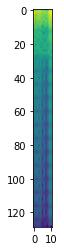

In [ ]:
new = np.array([data]).reshape(12,129,11)
plt.imshow(new[10])